# **Molecular Dynamics**
## Ali Ekramian  -  99100563

  0%|          | 0/4000 [00:00<?, ?it/s]

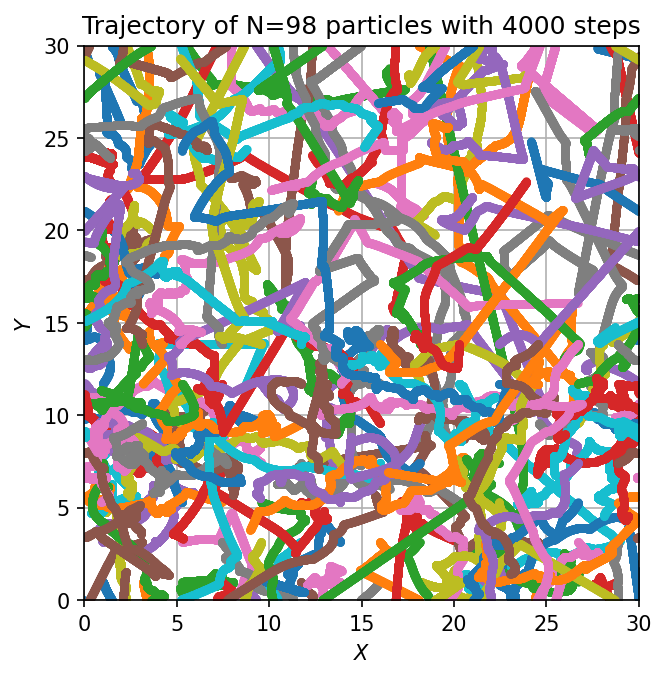

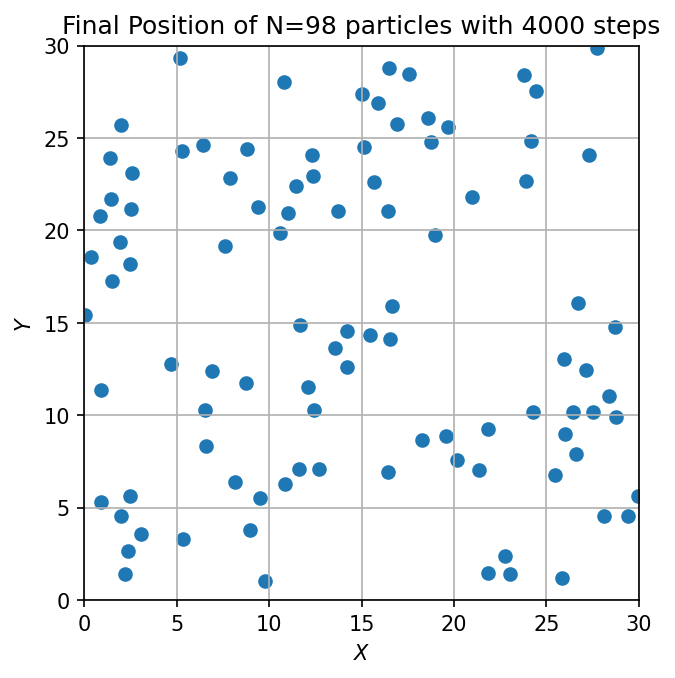

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

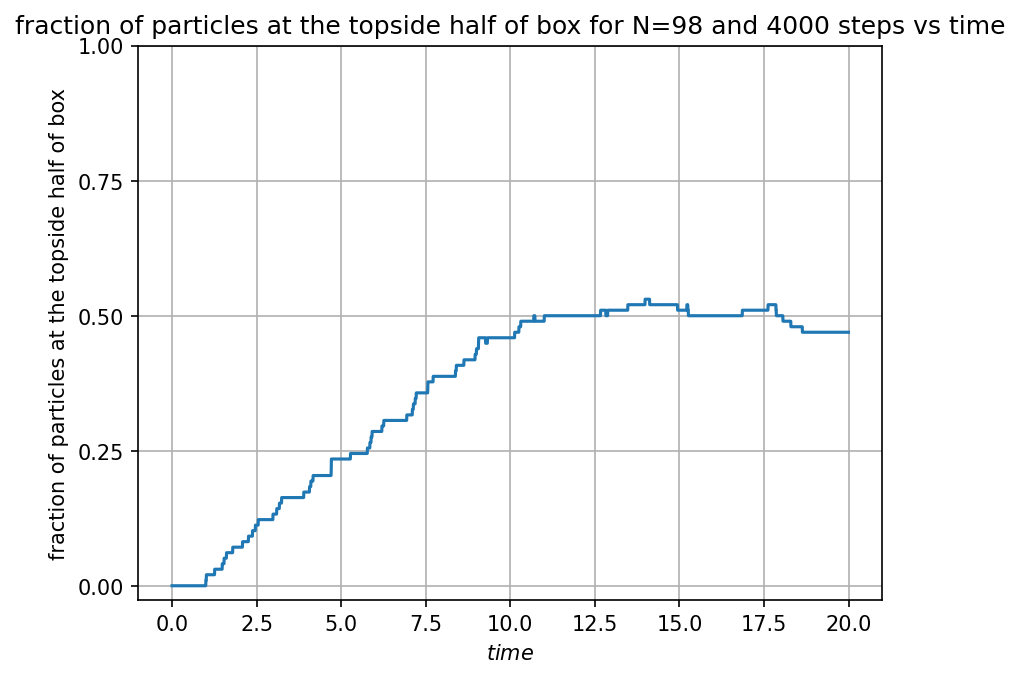

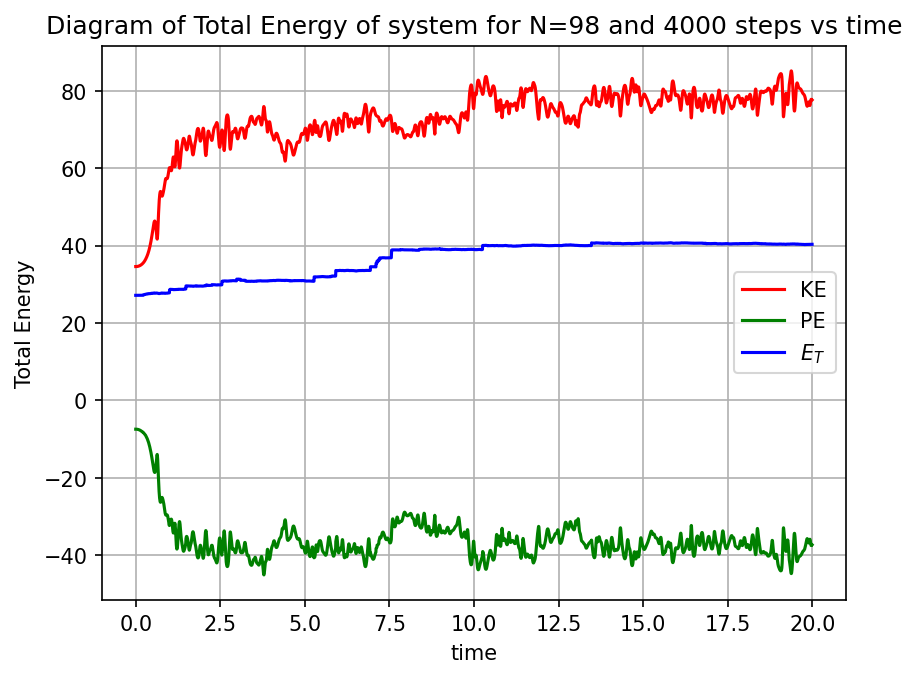

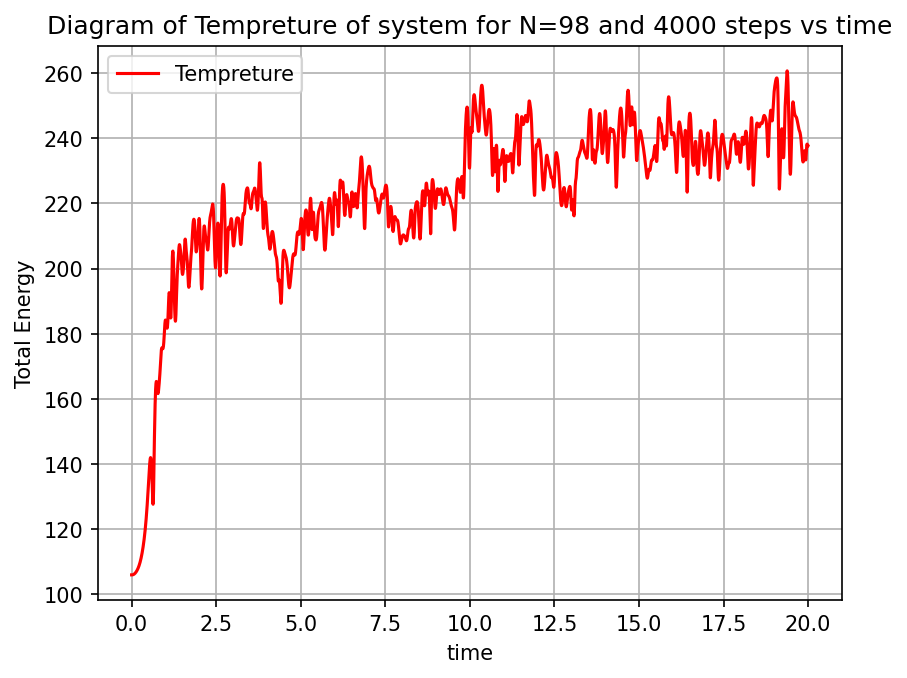

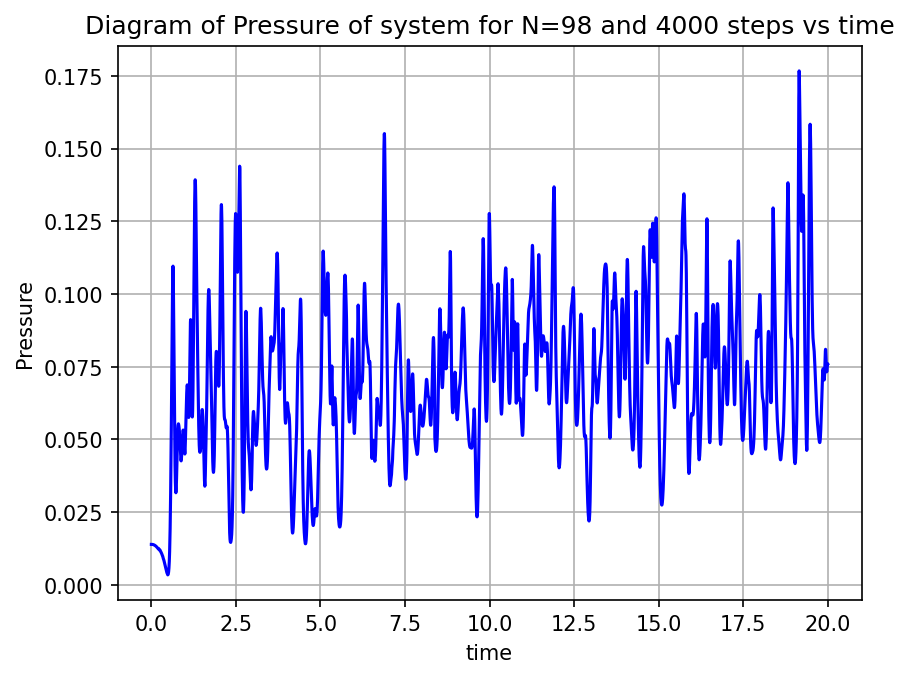

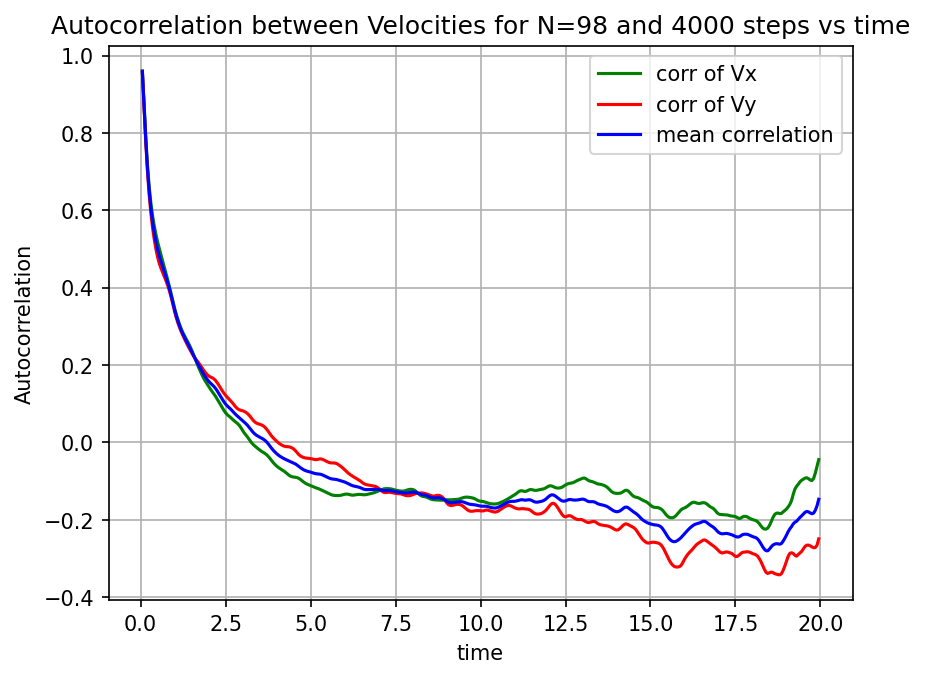

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
plt.rcParams['figure.dpi']=150
plt.rcParams['savefig.dpi']=100
N=98
L=30
h=0.005
T_f=20
steps=int(T_f/h)
sigma=1
epsilon=1
m=1
rc=2.5*sigma
h_half=0.5*h
h_2=h_half*h
Area=L*L
def u(r):
    return 4*epsilon*((sigma/r)**(12)-(sigma/r)**(6))
def f(r,xi):
    return -24*m*epsilon*(2*(sigma/r)**(12)-(sigma/r)**(6))*(xi)/(r*r)
def init():
    R=np.zeros((N,2))
    V=np.zeros((N,2))
    V_max=1
    np.random.seed(129)
    V=np.random.uniform(-V_max,V_max,size=(N,2))
    a=np.sqrt(L**2 / (2*N))
    nrow=int(L/(2*a))
    ncol=int(N/nrow)
    xx=np.linspace(0,L-a,ncol)
    yy=np.linspace(0,L/2-a,nrow)
    XX,YY=np.meshgrid(xx,yy)
    XX+=1
    YY+=1
    XX=XX.flatten()
    YY=YY.flatten()
    R = np.stack((XX,YY),axis=0).T
    #R=np.array([[1,1],[2,1]])
    #V=5*np.array([[1,1],[-1,1]])
    #R[:,0]=((np.arange(N)%3) +1)*L/6
    #R[:,1]=((np.arange(N)//3) +1)*L/12
    #for i in range(N):
    #    R[i]=[((i)%(L-1)+1),((i)//(L-1)+1)]
    #V_cm=np.sum(V,axis=0)/N
    #V =V-V_cm
    return R,V
"""def d(r1,r2):
    r12=r1-r2
    if np.abs(r1[0]-r2[0])<L-np.abs(r1[0]-r2[0]):
        r12[0]=np.abs(r1[0]-r2[0])
    else:
        r12[0]=(L-np.abs(r1[0]-r2[0]))*np.sign(r1[0]-r2[0])
    if np.abs(r1[1]-r2[1])<L-np.abs(r1[1]-r2[1]):
        r12[1]=np.abs(r1[1]-r2[1])
    else:
        r12[1]=(L-np.abs(r1[1]-r2[1]))*np.sign(r1[1]-r2[1])
    d=np.sqrt(np.sum(r12**2))
    return d,r12"""

def d(r1,r2):
    r12=r1-r2
    deltax=-(r1[0]-r2[0])
    deltay=-(r1[1]-r2[1])
    if np.abs(deltax)>L/2:
        deltax-=L*np.sign(deltax)
        if np.abs(deltay)>L/2:
            deltax-=L*np.sign(deltax)
            if abs(deltay)>L/2:
                deltay-=L*np.sign(deltay)
            elif abs(deltay)>L/2:
                deltay-=L*np.sign(deltay)
    d=np.sqrt(deltax*deltax+deltay*deltay)
    r12[0]=deltax
    r12[1]=deltay
    return d,r12


def U(R):
    U=np.zeros(N)
    for i in range(N):
        for j in range(i+1,N):
            r,r12=d(R[i],R[j])
            if r<rc:
                U[i]+=u(r)
    return U
def Force(R):
    Fx=np.zeros(N)
    Fy=np.zeros(N)
    for i in range(N):
        for j in range(i+1,N):
            r,r12=d(R[i],R[j])
            if r<rc:
                Fx[i]+=f(r,r12[0])
                Fx[j]-=f(r,r12[0])
                Fy[i]+=f(r,r12[1])
                Fy[j]-=f(r,r12[1])
    F=np.zeros((N,2))
    F[:,0],F[:,1]=Fx,Fy
    return F

def pr(R):
    Fx=np.zeros(N)
    Fy=np.zeros(N)
    sumx,sumy=0,0
    for i in range(N):
        for j in range(i+1,N):
            r,r12=d(R[i],R[j])
            if r<rc:
                sumx+=f(r,r12[0])*r12[0]
                sumy+=f(r,r12[1])*r12[1]
    return sumx+sumy

def verlet(R,V,A):
    V+=A*h_half
    R+=V*h
    A=Force(R)
    V+=h_half*A
    R=R%L
    return R,V,A
def sol(R,V):
    k1R=V*h
    k1V=Force(R)*h/m
    k2R=(V+0.5*k1V)*h
    k2V=Force(R+0.5*k1R)*h/m
    k3R=(V+0.5*k2V)*h
    k3V=Force(R+0.5*k2R)*h/m
    k4R=(V+k3V)*h
    k4V=Force(R+k3R)*h/m
    R_new=R+(k1R+2*k2R+2*k3R+k4R)/6
    R_new=R_new%L
    V_new=V+(k1V+2*k2V+2*k3V+k4V)/6
    return R_new,V_new,k1V
def KE(vx,vy):
    ke=0.5*m*(vx**2+vy**2)
    return ke
def PE(R):
    pe=U(R)
    return pe
def corr(Y):
    X=np.transpose(Y)
    #print(X)
    AC=np.zeros((N,len(Y)-1))
    for i in tqdm(range(N)):
        Cj=np.zeros(len(Y)-1)
        for j in range(1,len(Y)):
            cr=0
            for k in range(len(X[i])-j):
                cr+=X[i][k]*X[i][k+j]
            cr/=len(X[i])-j
            cr1=(np.mean(X[i]))**2
            var=np.var(X[i])
            corr_j=(cr-cr1)/var
            Cj[j-1]=corr_j
        AC[i]=Cj
    #print(AC)
    corr_arr=np.sum(AC,axis=0)/N
    return corr_arr
R,v=init()
#print(v)
X=np.zeros((steps,N))
Y=np.zeros((steps,N))
Vx=np.zeros((steps,N))
Vy=np.zeros((steps,N))
Us=np.zeros((steps,N))
Ps=np.zeros((steps))
up=np.zeros(steps)
time=np.arange(0,T_f,h)
kk=np.zeros(steps)
A=Force(R)
for i in tqdm(range(steps)):
    R,v,A=verlet(R,v,A)
    #R,v,k1=sol(R,v)
    kk[i]=A.max()
    #kk[i]=k1.max()
    X[i],Y[i]=R[0:,0],R[0:,-1]
    Vx[i],Vy[i]=v[0:,0],v[0:,-1]
    if np.sum(KE(Vx[i],Vy[i]))>1000:
        break
    Us[i]=PE(R)
    Ps[i]=pr(R)
    y_ups=[x for x in Y[i] if x>(L/2)]
    up[i]=len(y_ups)
K=KE(Vx,Vy)
Ps=Ps/(2*Area)
potential_energy=np.sum(Us,axis=1)
kinetic_energy=np.sum(K,axis=1)
Temp=kinetic_energy*300/N
Energy=potential_energy+kinetic_energy
Pressure=(kinetic_energy/Area)-(Ps)
#print('K=',kinetic_energy)
#print('U=',potential_energy)
#print(Energy)
plt.axes().set_aspect('equal')
for j in range(N):
    plt.plot(X[0:,j],Y[0:,j],'o',markersize=3)
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(f'Trajectory of N={N} particles with {steps} steps')
plt.grid(True)
plt.show()
plt.axes().set_aspect('equal')
plt.scatter(R[0:,0],R[0:,-1])
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.title(f'Final Position of N={N} particles with {steps} steps')
plt.grid(True)
plt.show()
Vy_reduced=[Vy[i] for i in range(len(Vx)) if i%10==0]
Vx_reduced=[Vx[i] for i in range(len(Vx)) if i%10==0]
corr_vy=corr(Vy_reduced)
corr_vx=corr(Vx_reduced)
#print(Vx_reduced)
#corr_vx=corr(Vx)
#corr_vy=corr(Vy)
corr_v=(corr_vx+corr_vy)/2
R,v=init()
plt.plot(time,up/N)
plt.yticks([0,0.25,0.5,0.75,1])
plt.xlabel(r'$time$')
plt.ylabel('fraction of particles at the topside half of box')
plt.title(f'fraction of particles at the topside half of box for N={N} and {steps} steps vs time')
plt.grid(True)
plt.show()
plt.plot(time,kinetic_energy,'r',label='KE')
plt.plot(time,potential_energy,'g',label='PE')
plt.plot(time,Energy,'b',label=r'$E_T$')
plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title(f'Diagram of Total Energy of system for N={N} and {steps} steps vs time')
plt.grid(True)
plt.legend()
plt.show()
plt.plot(time,Temp,'r',label='Tempreture')
plt.xlabel('time')
plt.ylabel('Total Energy')
plt.title(f'Diagram of Tempreture of system for N={N} and {steps} steps vs time')
plt.grid(True)
plt.legend()
plt.show()
plt.plot(time,Pressure,'b',label='Pressure')
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title(f'Diagram of Pressure of system for N={N} and {steps} steps vs time')
plt.grid(True)
#plt.legend()
plt.show()
ST=np.arange(1,len(Vx_reduced),1)/20
plt.plot(ST,corr_vx,'g',label='corr of Vx')
plt.plot(ST,corr_vy,'r',label='corr of Vy')
plt.plot(ST,corr_v,'b',label='mean correlation')
plt.xlabel('time')
plt.ylabel('Autocorrelation')
plt.title(f'Autocorrelation between Velocities for N={N} and {steps} steps vs time')
plt.grid(True)
plt.legend()
plt.show()